In [1]:
import pandas as pd
import datetime
import numpy as np

from forex.pre_training_data_prep.config import config

import pyspark.sql.functions as f
#from pyspark.sql.types import BooleanType, IntegerType, ArrayType, FloatType

In [2]:
config

{'database_name': 'django',
 'dag_id': 'NEW_prepare_forex_data',
 'tz_name': 'US/Eastern',
 'price_type_name': 'mid',
 'instrument_name': 'EUR/USD',
 'interval_name': 'Minute',
 'retries_pull_forex_data': 1,
 'retry_delay_minutes_pull_forex_data': 5,
 'directory_output': '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning/forex/output',
 'filename_candlesticks_query_results': 'candlesticks_query_results.parquet',
 'filename_timezone_added': 'candlesticks_timezone_added.parquet',
 'filename_offset': 'candlesticks_timezone_weekday_offset.parquet',
 'filename_weekday_shift_merged': 'candlesticks_weekday_offset_merged.parquet',
 'filename_shift_days_and_hours_as_needed': 'candlesticks_shifted_as_needed.parquet',
 'filename_finalized_pandas': 'candlesticks_finalized_pandas.parquet',
 'filename_conversion_to_spark': 'spark_converted.parquet',
 'filename_pivot_and_sort': 'spark_pivot_and_sort.parquet',
 'filename_timestamp_diff': 'spark_timestamp

## Get previous Pandas dataframe and put it into Spark

In [ ]:
from utilities.spark_session import get_spark_session
from utilities.spark_session import load_pandas_df_parquet_into_spark_df

spark = get_spark_session(config['spark_config'])

sdf_arrays = load_pandas_df_parquet_into_spark_df(
    config['directory_output'] + '/' + config['filename_finalized_pandas'],
    spark,
    truncate_to_row_number = None, #10,
    n_processors_to_coalesce = config['n_processors_to_coalesce'],
)

sdf_arrays.write.mode('overwrite').parquet(config['directory_output'] + '/' + config['filename_conversion_to_spark'])

In [ ]:
sdf_arrays.show(5)
spark.stop()

In [ ]:
from pyspark.sql.types import ArrayType, IntegerType, FloatType

In [ ]:
def difference_an_array(the_array, seconds_divisor):
    return [int((y - x) / seconds_divisor) for x, y in zip(the_array[0:-1], the_array[1:])]

udf_difference_an_array = f.udf(difference_an_array, ArrayType(IntegerType()))

def argsort_an_array(the_array):
    the_sort_order = np.argsort(np.array(the_array))
    return [int(x) for x in the_sort_order]

udf_argsort_an_array = f.udf(argsort_an_array, ArrayType(IntegerType()))

def apply_argsort_integer(the_array, argsort_array):
    return [int(x) for x in np.array(the_array)[argsort_array]]

def apply_argsort_float(the_array, argsort_array):
    return [float(x) for x in np.array(the_array)[argsort_array]]

udf_apply_argsort_integer = f.udf(apply_argsort_integer, ArrayType(IntegerType()))
udf_apply_argsort_float = f.udf(apply_argsort_float, ArrayType(FloatType()))

In [ ]:
def task_pivot_and_sort_arrays(**config):

    spark = get_spark_session(config['spark_config'])
    sdf_arrays = (

        #
        # load
        #
        spark.read.parquet(config['directory_output'] + '/' + config['filename_conversion_to_spark'])
        
        #
        # pivot
        #
        .select('original_date_shifted', 'timestamp', 'Return', 'Volatility', 'lhc_mean', 'volume')
        .withColumnRenamed('original_date_shifted', 'date_post_shift')
        .orderBy('timestamp')
        .groupBy('date_post_shift')
        .agg(
            f.collect_list('timestamp').alias('timestamp_array'),
            f.collect_list('Return').alias('return_array'),
            f.collect_list('Volatility').alias('volatility_array'),
            f.collect_list('lhc_mean').alias('lhc_mean_array'),
            f.collect_list('volume').alias('volume_array'),
        )

        #
        # ensure proper sorting (probably not necessary but insurance)
        #
        .withColumn(
            'timestamp_argsort',
            udf_argsort_an_array(f.col('timestamp_array'))
        )
        .withColumn('sorted_timestamp_array', udf_apply_argsort_integer(f.col('timestamp_array'), f.col('timestamp_argsort')))
        .withColumn('sorted_return_array', udf_apply_argsort_float(f.col('return_array'), f.col('timestamp_argsort')))
        .withColumn('sorted_volatility_array', udf_apply_argsort_float(f.col('volatility_array'), f.col('timestamp_argsort')))
        .withColumn('sorted_lhc_mean_array', udf_apply_argsort_float(f.col('lhc_mean_array'), f.col('timestamp_argsort')))
        .withColumn('sorted_volume_array', udf_apply_argsort_float(f.col('volume_array'), f.col('timestamp_argsort')))

        .drop('timestamp_argsort', 'timestamp_array', 'return_array', 'volatility_array', 'lhc_mean_array', 'volume_array')
        .orderBy('date_post_shift')
    )
    sdf_arrays.write.mode('overwrite').parquet(config['directory_output'] + '/' + config['filename_pivot_and_sort'])
    spark.stop()

def task_diff_the_timestamp_arrays(**config):
    spark = get_spark_session(config['spark_config'])
    sdf_arrays = (
        spark.read.parquet(config['directory_output'] + '/' + config['filename_pivot_and_sort'])
        .withColumn('seconds_divisor', f.lit(config['seconds_divisor']))
        .withColumn(
            'diff_sorted_timestamp_array',
            udf_difference_an_array(
                f.col('sorted_timestamp_array'),
                f.col('seconds_divisor'),
            )
        )
        .drop('seconds_divisor')
        .orderBy('date_post_shift')
    )
    sdf_arrays.write.mode('overwrite').parquet(config['directory_output'] + '/' + config['filename_timestamp_diff'])
    spark.stop()

In [ ]:
task_pivot_and_sort_arrays(**config)

In [ ]:
task_diff_the_timestamp_arrays(**config)

In [4]:
from pyspark.sql.types import ArrayType, IntegerType, FloatType

In [5]:
def get_all_timestamps(timestamp_array, seconds_divisor):
    return [int(x) for x in range(min(timestamp_array), max(timestamp_array) + seconds_divisor, seconds_divisor)]

udf_get_all_timestamps = f.udf(get_all_timestamps, ArrayType(IntegerType()))

##https://stackoverflow.com/questions/41190852/most-efficient-way-to-forward-fill-nan-values-in-numpy-array
#def do_nans_exist(values_array):
#    values_array = np.array([np.array(values_array)])
#    mask = np.isnan(values_array)
#    has_nan_0_or_1 = np.max([int(x) for x in mask[0]])
#    return int(has_nan_0_or_1)
#
#udf_do_nans_exist = f.udf(do_nans_exist, IntegerType())

##https://stackoverflow.com/questions/41190852/most-efficient-way-to-forward-fill-nan-values-in-numpy-array
#def do_non_nans_exist(values_array):
#    values_array = np.array([np.array(values_array)])
#    mask = ~np.isnan(values_array)
#    has_non_nan_0_or_1 = np.max([int(x) for x in mask[0]])
#    return int(has_non_nan_0_or_1)
#    
#udf_do_non_nans_exist = f.udf(do_non_nans_exist, IntegerType())


def count_nans_in_array(values_array):
    values_array = np.array([np.array(values_array)])
    mask = np.isnan(values_array)
    nan_count = np.sum([int(x) for x in mask[0]])
    return int(nan_count)
    
udf_count_nans_in_array = f.udf(count_nans_in_array, IntegerType())



##https://stackoverflow.com/questions/41190852/most-efficient-way-to-forward-fill-nan-values-in-numpy-array
#def forward_fill(values_array):
#    arr = np.array([values_array])
#    mask = np.isnan(arr)
#    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
#    np.maximum.accumulate(idx, axis = 1, out = idx)
#    arr[mask] = arr[np.nonzero(mask)[0], idx[mask]]
#    to_return = list([float(x) for x in arr[0]])
#    return to_return
#
#udf_forward_fill = f.udf(forward_fill, ArrayType(FloatType()))


def locate_nans(timestamp_array, timestamp_all_array, values_array):

    # make sure we get an argsort in here later to ensure order of values is correct

    ts = np.array(timestamp_array, dtype = np.uint64) # ??
    ts_all = np.array(timestamp_all_array, dtype = np.uint64)  # we can probably make this smaller
    v = np.array(values_array, dtype = np.float64)  # we can probably make this smaller
    
    pdf = pd.DataFrame({'timestamp' : ts, 'values' : v})
    pdf_all = pd.DataFrame({'timestamp' : ts_all})

    pdf_joined = (
        pd.merge(
            pdf_all,
            pdf,
            on = 'timestamp',
            how = 'left',
        )
    )

    to_return = pdf_joined['values'].to_list()
    
    return to_return

udf_locate_nans = f.udf(locate_nans, ArrayType(FloatType()))

In [6]:
from utilities.spark_session import get_spark_session

def meh(**config):

    spark = get_spark_session(config['spark_config'])
    sdf_arrays = (
        spark.read.parquet(config['directory_output'] + '/' + config['filename_timestamp_diff'])
        .coalesce(config['n_processors_to_coalesce'])
        .orderBy('date_post_shift')

        .drop('timestamp_argsort')   # done above just not reflected in the saved data

        .withColumn(
            'timestamps_all',
            udf_get_all_timestamps(f.col('sorted_timestamp_array'), f.lit(config['seconds_divisor']))
        )
    )

    items_list = ['return', 'volatility', 'volume', 'lhc_mean']
    
    for item in items_list:
        sdf_arrays = (
            sdf_arrays
            .withColumn(
                item + '_and_nans',
                udf_locate_nans(f.col('sorted_timestamp_array'), f.col('timestamps_all'), f.col('sorted_' + item + '_array'))
            )
            #.withColumn(
            #    item + '_forward_filled',
            #    udf_forward_fill(f.col(item + '_and_nans'))
            #)
        )

    for item in items_list:
        sdf_arrays = (
            sdf_arrays
            .withColumn(
                item + '_nan_count',
                udf_count_nans_in_array(f.col(item + '_and_nans'))
            )
        )

    # QA
    #sdf_arrays = (
    #    sdf_arrays
    #    .withColumn(
    #        'test_nan_count_equality',
    #        (
    #            (f.col('return_nan_count') == f.col('volatility_nan_count')) &
    #            (f.col('volatility_nan_count') == f.col('volume_nan_count')) &
    #            (f.col('volume_nan_count') == f.col('lhc_mean_nan_count'))
    #        )
    #    )
    #)
    #sdf_test = sdf_arrays.groupBy('test_nan_count_equality').agg(f.count(f.col('date_post_shift').alias('test_nan_count_equality_aggregated')))
    #sdf_test.show()
    #sdf_test = sdf_test.drop('test_nan_count_equality')

    sdf_arrays = sdf_arrays.withColumn('nan_count_full_day', f.col('return_nan_count'))
    for item in items_list:
        sdf_arrays = sdf_arrays.drop(item + '_nan_count')

    sdf_arrays.write.mode('overwrite').parquet(config['directory_output'] + '/' + config['filename_full_day_nans'])
    spark.stop()

meh(**config)

25/03/10 09:25:15 WARN Utils: Your hostname, emily-MS-7B96 resolves to a loopback address: 127.0.1.1; using 192.168.1.82 instead (on interface wlp5s0)
25/03/10 09:25:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/10 09:25:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [32]:
from utilities.spark_session import get_spark_session
spark = get_spark_session(config['spark_config'])
sdf_qa = (
    spark.read.parquet(config['directory_output'] + '/' + config['filename_full_day_nans'])
    .select('nan_count_full_day', 'date_post_shift')
    .orderBy(f.col('nan_count_full_day').desc())
    .withColumn('has_nans', f.col('nan_count_full_day') > 0)
    .groupBy('has_nans').agg(f.count('date_post_shift').alias('number_of_days'))
)
sdf_qa.show()

+--------+--------------+
|has_nans|number_of_days|
+--------+--------------+
|    true|          4119|
|   false|           128|
+--------+--------------+



In [33]:
spark = get_spark_session(config['spark_config'])
sdf_qa_counts = (
    spark.read.parquet(config['directory_output'] + '/' + config['filename_full_day_nans'])
    .select('nan_count_full_day', 'date_post_shift')
    .orderBy(f.col('nan_count_full_day').desc())
)
sdf_qa_counts.show()

+------------------+---------------+
|nan_count_full_day|date_post_shift|
+------------------+---------------+
|              1363|     2009-01-01|
|               671|     2019-04-19|
|               653|     2011-12-26|
|               502|     2016-03-25|
|               471|     2019-12-26|
|               467|     2019-05-27|
|               453|     2009-12-25|
|               422|     2014-09-01|
|               389|     2019-04-22|
|               388|     2012-01-02|
|               371|     2019-07-04|
|               370|     2023-01-02|
|               367|     2014-08-11|
|               357|     2018-03-30|
|               343|     2014-08-13|
|               335|     2014-12-26|
|               332|     2010-12-24|
|               324|     2019-11-29|
|               319|     2019-11-28|
|               316|     2011-04-22|
+------------------+---------------+
only showing top 20 rows



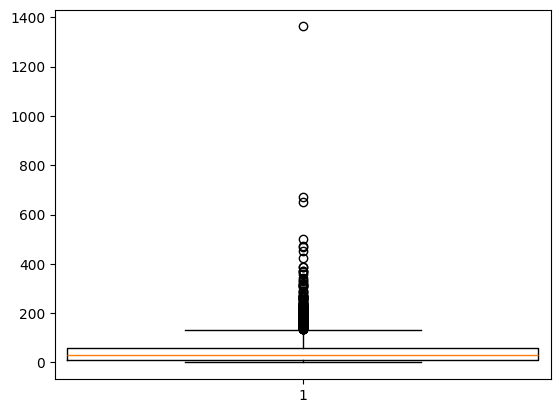

In [34]:
import matplotlib.pyplot as plt
nan_counts_per_day = [x['nan_count_full_day'] for x in sdf_qa_counts.select('nan_count_full_day').collect()]

#plt.figure()
#plt.hist(nan_counts_per_day)
#plt.show()
#plt.close()

plt.figure()
plt.boxplot([nan_counts_per_day], widths=0.95)
plt.show()
plt.close()

In [28]:
print(np.mean(nan_counts_per_day), np.median(nan_counts_per_day))

46.816105486225574 32.0


In [52]:
pdf_qa_dates = sdf_qa_counts.toPandas()

<Figure size 640x480 with 0 Axes>

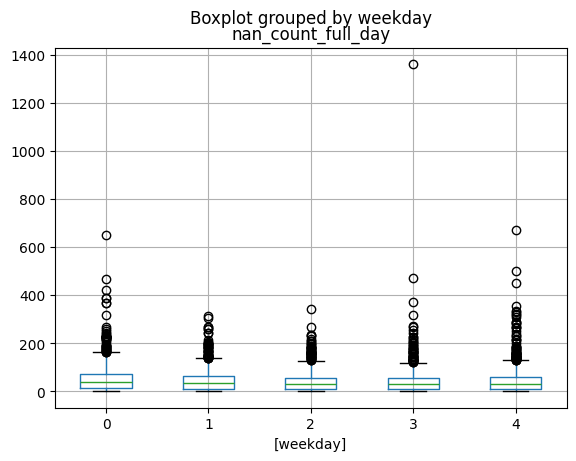

In [56]:
pdf_qa_dates['weekday'] = [x.weekday() for x in pdf_qa_dates['date_post_shift']]

plt.figure()
pdf_qa_dates.boxplot(by = 'weekday')
plt.show()
plt.close()

In [59]:
sdf_arrays = spark.read.parquet(config['directory_output'] + '/' + config['filename_full_day_nans'])
sdf_arrays.show(5)

+---------------+----------------------+--------------------+-----------------------+---------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|date_post_shift|sorted_timestamp_array| sorted_return_array|sorted_volatility_array|sorted_lhc_mean_array| sorted_volume_array|diff_sorted_timestamp_array|      timestamps_all|     return_and_nans| volatility_and_nans|     volume_and_nans|   lhc_mean_and_nans|nan_count_full_day|
+---------------+----------------------+--------------------+-----------------------+---------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|     2014-11-19|  [1416348120, 1416...|[-2.2E-4, 1.8E-4,...|   [3.4E-4, 2.2E-4, ...| [1.2532933, 1.253...|[17.0, 18.0, 5.0,...|       [1, 1, 1, 1, 1, 1...|[

In [83]:
[x['return_and_nans'] for x in sdf_arrays.select('return_and_nans').take(1)][0][0:20]
#[x['return_and_nans'] for x in sdf_arrays.select('return_and_nans').take(1)]

[-0.00022000000171829015,
 0.00018000000272877514,
 7.999999797903001e-05,
 -0.00013000000035390258,
 0.00015999999595806003,
 -9.999999747378752e-06,
 0.0,
 0.0,
 9.999999747378752e-06,
 1.9999999494757503e-05,
 nan,
 -2.9999999242136255e-05,
 -0.00011999999696854502,
 -0.00011000000085914508,
 -9.999999747378752e-06,
 1.9999999494757503e-05,
 nan,
 nan,
 4.999999873689376e-05,
 0.0002300000051036477]

In [70]:
# https://stackoverflow.com/questions/6352425/whats-the-most-pythonic-way-to-identify-consecutive-duplicates-in-a-list



In [137]:
sdf_arrays.show(5)

+---------------+----------------------+--------------------+-----------------------+---------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------+
|date_post_shift|sorted_timestamp_array| sorted_return_array|sorted_volatility_array|sorted_lhc_mean_array| sorted_volume_array|diff_sorted_timestamp_array|      timestamps_all|     return_and_nans| volatility_and_nans|     volume_and_nans|   lhc_mean_and_nans|nan_count_full_day|booger|
+---------------+----------------------+--------------------+-----------------------+---------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------+
|     2014-11-19|  [1416348120, 1416...|[-2.2E-4, 1.8E-4,...|   [3.4E-4, 2.2E-4, ...| [1.2532933, 1.253...|[17.0, 18.0, 5.0,...|       [

In [142]:
#
# Had to implement a crude method to get this to work in Spark.
#
# A more elegant solution is described at:
# https://stackoverflow.com/questions/6352425/whats-the-most-pythonic-way-to-identify-consecutive-duplicates-in-a-list
#
def get_max_consecutive_NaNs(a_list):

    n_consec_nan_list = []
    count = 0
    is_in_nan_group = False
    for item in np.array(a_list):
        if np.isnan(item) or item == None:
            is_in_nan_group = True
            count += 1
        if not np.isnan(item) and is_in_nan_group:
            is_in_nan_group = False
            n_consec_nan_list.append(count)
            count = 0
        
    return max(n_consec_nan_list)
    
udf_get_max_consecutive_NaNs = f.udf(get_max_consecutive_NaNs, IntegerType())
sdf_arrays = (
    sdf_arrays
   .withColumn('consec_nans_return', udf_get_max_consecutive_NaNs(f.col('return_and_nans')))
   .withColumn('consec_nans_volatility', udf_get_max_consecutive_NaNs(f.col('volatility_and_nans')))
   .withColumn('consec_nans_volume', udf_get_max_consecutive_NaNs(f.col('volume_and_nans')))
   .withColumn('consec_nans_lhc_mean', udf_get_max_consecutive_NaNs(f.col('lhc_mean_and_nans')))

)
sdf_arrays.select('consec_nans_return', 'consec_nans_volatility', 'consec_nans_volume', 'consec_nans_lhc_mean').show(5)

+------------------+----------------------+------------------+--------------------+
|consec_nans_return|consec_nans_volatility|consec_nans_volume|consec_nans_lhc_mean|
+------------------+----------------------+------------------+--------------------+
|                 4|                     4|                 4|                   4|
|                 2|                     2|                 2|                   2|
|                 5|                     5|                 5|                   5|
|                 5|                     5|                 5|                   5|
|                 3|                     3|                 3|                   3|
+------------------+----------------------+------------------+--------------------+
only showing top 5 rows

